### 1. data preprocessing preprocessed the data frames from Gorilla Similarity task
### 2. within_category_similarity_distance use the preprocessed data frame and find the average rating within category
### 3. trialBased_SDperformance find the unique sequence and their percentage correctness (choose only absent block with if statement)
### 4. plot_relationship: combined rating and correctness plot relationsip

### Import Library

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import pearsonr, t
import seaborn as sns

In [114]:
#Everyday/Complex Tone: Function to find mean and min distances
def calculate_distances(sequence, switch, distance_data):
    # Split the sequence string into a list and remove any leading/trailing spaces from each element
    sequence_list = [item.strip() for item in sequence.split(',')]

    # Ensure switch is a valid index
    if switch < 0 or switch >= len(sequence_list) - 1:
        return "Invalid switch value or sequence too short"

    # Helper function to find the similarity distance between two notes
    def find_distance(note1, note2):
        # Attempt to find the distance in the dataset
        row = distance_data[(distance_data['Spreadsheet: A'] == f"{note1}.wav") & (distance_data['Spreadsheet: B'] == f"{note2}.wav")]
        if not row.empty:
            return row['Similarity_Distance'].iloc[0]
        else:
            # If not found, check the reverse order
            row = distance_data[(distance_data['Spreadsheet: A'] == f"{note2}.wav") & (distance_data['Spreadsheet: B'] == f"{note1}.wav")]
            if not row.empty:
                return row['Similarity_Distance'].iloc[0]
        # Return None if no data found
        return None

    # Calculate differences based on the switch position
    if switch == 0:
        # # swapped differences |AB|
        # swapped_distance = find_distance(sequence_list[0], sequence_list[1]) # dissimilar
        # For the first swap position (0), calculate |AC - BC|
        ac_distance = find_distance(sequence_list[0], sequence_list[2])
        bc_distance = find_distance(sequence_list[1], sequence_list[2])
        if ac_distance is not None and bc_distance is not None:
            return ac_distance - bc_distance  #+ swapped_distance
    elif switch == 1:
        # # swapped differences |BC|
        # swapped_distance = find_distance(sequence_list[1], sequence_list[2]) # dissimilar
        # For the second swap position (1), calculate |AC - AB| + |BD - CD|
        ac_distance = find_distance(sequence_list[0], sequence_list[2])
        ab_distance = find_distance(sequence_list[0], sequence_list[1])
        bd_distance = find_distance(sequence_list[1], sequence_list[3])
        cd_distance = find_distance(sequence_list[2], sequence_list[3])
        differences = []
        if ac_distance is not None and ab_distance is not None:
            differences.append(ac_distance - ab_distance)
        if bd_distance is not None and cd_distance is not None:
            differences.append(bd_distance - cd_distance)
        if differences:
            return differences[0] #sum(differences) #+swapped_distance
    elif switch == 2:
        # # swapped differences |CD|
        # swapped_distance = find_distance(sequence_list[2], sequence_list[3]) # dissimilar
        # For the third swap position (2), calculate |BD - BC|
        bd_distance = find_distance(sequence_list[1], sequence_list[3])
        bc_distance = find_distance(sequence_list[1], sequence_list[2])
        if bd_distance is not None and bc_distance is not None:
            return bd_distance - bc_distance #+ swapped_distance

    # If any case does not return, it means necessary distances were not found
    return "N/A"


# Cat Meows ONlY; Function to find mean and min distances
def calculate_distances2(sequence, switch, distance_data):
    # Split the sequence string into a list and remove any leading/trailing spaces from each element
    sequence_list = [item.strip().split('_', 1)[0] for item in sequence.split(',')]

    # Ensure switch is a valid index
    if switch < 0 or switch >= len(sequence_list) - 1:
        return "Invalid switch value or sequence too short"

    # Helper function to find the similarity distance between two notes
    def find_distance(note1, note2):
        # Attempt to find the distance in the dataset, appending '_300ms.wav' to each note
        row = distance_data[(distance_data['Spreadsheet: A'] == f"{note1}_300ms.wav") & (distance_data['Spreadsheet: B'] == f"{note2}_300ms.wav")]
        if not row.empty:
            return row['Similarity_Distance'].iloc[0]
        else:
            # If not found, check the reverse order
            row = distance_data[(distance_data['Spreadsheet: A'] == f"{note2}_300ms.wav") & (distance_data['Spreadsheet: B'] == f"{note1}_300ms.wav")]
            if not row.empty:
                return row['Similarity_Distance'].iloc[0]
        # Return None if no data found
        return None

    # Calculate differences based on the switch position
    if switch == 0:
        # swapped differences |AB|
        swapped_distance = find_distance(sequence_list[0], sequence_list[1]) # dissimilar
        # For the first swap position (0), calculate |AC - BC|
        ac_distance = find_distance(sequence_list[0], sequence_list[2])
        bc_distance = find_distance(sequence_list[1], sequence_list[2])
        if ac_distance is not None and bc_distance is not None:
            return ac_distance - bc_distance #+ swapped_distance
    elif switch == 1:
        # swapped differences |AB|
        swapped_distance = find_distance(sequence_list[1], sequence_list[2]) # dissimilar
        # For the second swap position (1), calculate |AC - AB| + |BD - CD|
        ac_distance = find_distance(sequence_list[0], sequence_list[2])
        ab_distance = find_distance(sequence_list[0], sequence_list[1])
        bd_distance = find_distance(sequence_list[1], sequence_list[3])
        cd_distance = find_distance(sequence_list[2], sequence_list[3])
        differences = []
        if ac_distance is not None and ab_distance is not None:
            differences.append(abs(ac_distance - ab_distance))
        if bd_distance is not None and cd_distance is not None:
            differences.append(abs(bd_distance - cd_distance))
        if differences:
            return sum(differences) #+ swapped_distance
    elif switch == 2:
        # swapped differences |AB|
        swapped_distance = find_distance(sequence_list[2], sequence_list[3]) # dissimilar
        # For the third swap position (2), calculate |BD - BC|
        bd_distance = find_distance(sequence_list[1], sequence_list[3])
        bc_distance = find_distance(sequence_list[1], sequence_list[2])
        if bd_distance is not None and bc_distance is not None:
            return bd_distance - bc_distance #+ swapped_distance

    # If any case does not return, it means necessary distances were not found
    return "N/A"
  

def plot_distances1(filtered_df_everyday, filtered_df_complexTone):
    # Plot for Distance
    plt.scatter(filtered_df_everyday['Distance'], filtered_df_everyday['Correctness'], color='green', label='Everyday')
    plt.scatter(filtered_df_complexTone['Distance'], filtered_df_complexTone['Correctness'], color='red', label='ComplexTone')
    #plt.xlim([0, 6])
    plt.ylim([0, 1.2])
    # Set y-axis tick labels to only include 0 to 1
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('Correctness vs. Distance')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_distances2(filtered_df_cat, filtered_df_complexTone):
    # Plot for Distance
    plt.scatter(filtered_df_cat['Distance'], filtered_df_cat['Correctness'], color='blue', label='Cat')
    plt.scatter(filtered_df_complexTone['Distance'], filtered_df_complexTone['Correctness'], color='red', label='ComplexTone')
    #plt.xlim([0, 6])
    plt.ylim([0, 1.2])
    # Set y-axis tick labels to only include 0 to 1
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('Correctness vs. Distance')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_distances_combined(filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2):
    # Plot for Distance
    plt.scatter(filtered_df_everyday['Distance'], filtered_df_everyday['Correctness'], color='green', label='Everyday')
    plt.scatter(filtered_df_complexTone1['Distance'], filtered_df_complexTone1['Correctness'], color='lightcoral', label='ComplexTone1')
    plt.scatter(filtered_df_cat['Distance'], filtered_df_cat['Correctness'], color='blue', label='Cat')
    plt.scatter(filtered_df_complexTone2['Distance'], filtered_df_complexTone2['Correctness'], color='darkred', label='ComplexTone2')
    #plt.xlim([0, 6])
    plt.ylim([0, 1.2])
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('Correctness vs. Distance')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_distances_with_regression(filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2):
    # Plot for Distance
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_everyday, color='green', label='Everyday')
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_complexTone1, color='lightcoral', label='ComplexTone1')
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_cat, color='blue', label='Cat')
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_complexTone2, color='darkred', label='ComplexTone2')
    plt.xlim([0, 5.5])
    plt.ylim([0, 1.2])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('Correctness vs. Distance')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_distances_2x2_subplots(filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2):
    plt.figure(figsize=(12, 12))

    # Subplot for ComplexTone1
    plt.subplot(2, 2, 1)
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_complexTone1, color='lightcoral', label='ComplexTone1')
    #plt.xlim([0, 6])
    plt.ylim([0, 1.2])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('ComplexTone1: Correctness vs. Distance')
    plt.legend()

    # Subplot for Everyday
    plt.subplot(2, 2, 2)
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_everyday, color='green', label='Everyday')
    #plt.xlim([0, 6])
    plt.ylim([0, 1.2])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('Everyday: Correctness vs. Distance')
    plt.legend()

    # Subplot for Cat
    plt.subplot(2, 2, 3)
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_cat, color='blue', label='Cat')
    #plt.xlim([0, 6])
    plt.ylim([0, 1.2])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('Cat: Correctness vs. Distance')
    plt.legend()

    # Subplot for ComplexTone2
    plt.subplot(2, 2, 4)
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_complexTone2, color='darkred', label='ComplexTone2')
    #plt.xlim([0, 6])
    plt.ylim([0, 1.2])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('ComplexTone2: Correctness vs. Distance')
    plt.legend()

    plt.tight_layout()
    plt.show()

def modified_plot_distances_with_regression(filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2):
    # Combine all dataframes for overall regression
    combined_df = pd.concat([filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2])
    
    plt.figure(figsize=(8, 8))

    # Plotting individual datasets with scatter and regression lines without confidence bands
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_everyday, color='green', label='Everyday', ci=None)
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_complexTone1, color='lightcoral', label='ComplexTone1', ci=None)
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_cat, color='blue', label='Cat', ci=None)
    sns.regplot(x='Distance', y='Correctness', data=filtered_df_complexTone2, color='darkred', label='ComplexTone2', ci=None)

    # Plotting the combined regression line with a confidence band
    #sns.regplot(x='Distance', y='Correctness', data=combined_df, color='black', scatter=False, ci=95, line_kws={"color": "black"})

    #plt.xlim([0, 6])
    plt.ylim([0, 1.1])
    plt.xlabel('Distance')
    plt.ylabel('Percent Correctness')
    plt.title('Correctness vs. Distance')
    #plt.legend()

    plt.tight_layout()
    # save_path = os.path.join('/Users/willmacbookair/Downloads/Poster plot', "different_relationship.svg")
    # # save the plot
    # plt.savefig(save_path, format='svg')
    plt.show()

def calculate_and_print_correlation(df, distance_type):
    # Extract category from dataframe variable name
    category = df.name.split('_')[-1]  # Assuming the df has a 'name' attribute set

    # Calculate Pearson correlation
    corr, _ = pearsonr(df[distance_type], df['Correctness'])
    
    # Calculate t-value and p-value
    n = len(df) 
    t_value = corr * np.sqrt((n - 2) / (1 - corr**2))
    df_degrees = n - 2
    p_value = 2 * (1 - t.cdf(np.abs(t_value), df_degrees))

    # Print results
    print(f"r ({category} - {distance_type}): {corr:.3f}, t-value: {t_value:.3f}, p-value: {p_value:.3f}, dof: {df_degrees}")


### Plot the relation sequence correctness and similarity distance 

#### Experiment 2a everyday sound & complex tones

In [115]:
# Everyday Sound
# distance metric
distanceED= "/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/8. Similarity in PA task/result/distance_everydaySound.csv"
# everyday sound
everydayCorrectness = "/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/9. Similarity in SD task/Everyday_CompexTone_result/correctness_other.csv"

# Reading the CSV files
distance_df = pd.read_csv(distanceED)
correctness_df = pd.read_csv(everydayCorrectness)

# Processing the correctness data
results = []
for index, row in correctness_df.iterrows():
    
    sequence_names = row['Sequence_Names']
    switch_name = row['Stim_Ind']
    percent_correctness = row['Percent_Correctness']

    distance = calculate_distances(sequence_names, switch_name, distance_df)
   
    results.append({
        'Sequence': sequence_names,
        'Switch': switch_name,
        'Correctness': percent_correctness,
        'Distance': abs(distance),
    })

results_df_everyday = pd.DataFrame(results)
print(results_df_everyday)
# Filter out the rows where distance is -1
filtered_df_everyday = results_df_everyday[(results_df_everyday['Distance'] != 1)]
print(filtered_df_everyday)



                                             Sequence  Switch  Correctness  \
0    baby_3ms, car_horn_3ms, car_engine_3ms, frog_3ms     2.0        0.650   
1   baby_3ms, drink_water_3ms, phone_ring_3ms, sno...     0.0        0.675   
2      baby_3ms, snore_3ms, laugh_3ms, car_engine_3ms     1.0        0.500   
3     bell_3ms, baby_3ms, sizzling_pan_3ms, cough_3ms     2.0        0.500   
4   cough_3ms, snore_3ms, brush_teeth_3ms, sizzlin...     0.0        0.750   
5   drink_water_3ms, brush_teeth_3ms, frog_3ms, fo...     0.0        0.475   
6   drink_water_3ms, frog_3ms, sizzling_pan_3ms, m...     1.0        0.425   
7   drink_water_3ms, sizzling_pan_3ms, car_engine_...     1.0        0.375   
8   drink_water_3ms, sizzling_pan_3ms, phone_ring_...     0.0        0.275   
9   foot_step_3ms, sheep_3ms, frog_3ms, car_engine...     0.0        0.700   
10  frog_3ms, foot_step_3ms, drink_water_3ms, sizz...     1.0        0.350   
11  laugh_3ms, brush_teeth_3ms, sizzling_pan_3ms, ...     2.0   

In [116]:
# Complex Tones 
# distance metric
distanceCT= "/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/8. Similarity in PA task/result/distance_complexTone2.csv"
# complex tone
complexToneCorrectness = '/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/9. Similarity in SD task/Everyday_CompexTone_result/correctness_complexTone.csv'

# Reading the CSV files
distance_df = pd.read_csv(distanceCT)
correctness_df = pd.read_csv(complexToneCorrectness)

# Processing the correctness data
results = []
for index, row in correctness_df.iterrows():
    
    sequence_names = row['Sequence_Names']
    switch_name = row['Stim_Ind']
    percent_correctness = row['Percent_Correctness']

    distance = calculate_distances(sequence_names, switch_name, distance_df)
   
    results.append({
        'Sequence': sequence_names,
        'Switch': switch_name,
        'Correctness': percent_correctness,
        'Distance': abs(distance),
    })

results_df_complexTone = pd.DataFrame(results)
filtered_df_complexTone1 = results_df_complexTone[(results_df_complexTone['Distance'] != 1)]
print(filtered_df_complexTone1)

                         Sequence  Switch  Correctness  Distance
0        A#4_Bb4, C4, F4, C#4_Db4     2.0        0.950  2.590909
1        A#4_Bb4, D4, B4, G#4_Ab4     2.0        0.950  0.575000
2             B4, D4, G#4_Ab4, D5     2.0        0.975  1.485714
3        C#5_Db5, C4, F#4_Gb4, B4     2.0        0.975  0.384615
4        C#5_Db5, C5, F#4_Gb4, B4     1.0        0.775  1.352273
5   C#5_Db5, D#4_Eb4, F4, A#4_Bb4     0.0        0.900  2.687500
6        C4, F#4_Gb4, G4, G#4_Ab4     2.0        0.950  0.000000
7             C4, G4, F4, C#5_Db5     1.0        0.650  0.034091
8             C5, G#4_Ab4, A4, C4     0.0        0.950  1.222222
9        D#4_Eb4, C5, E4, C#4_Db4     0.0        0.875  3.250000
10       D#5_Eb5, F4, A4, A#4_Bb4     1.0        0.600  0.066667
11       D4, F#4_Gb4, F4, C#5_Db5     0.0        0.800  0.585714
12            D5, A#4_Bb4, C4, C5     1.0        0.625  2.454545
13            D5, F#4_Gb4, G4, E4     1.0        0.750  0.525000
14            E4, D4, D5,

#### correlation analysis 

In [117]:
##
filtered_df_everyday.name = 'filtered_df_everyday'
filtered_df_complexTone1.name = 'filtered_df_complexTone'

calculate_and_print_correlation(filtered_df_everyday, 'Distance')
calculate_and_print_correlation(filtered_df_complexTone1, 'Distance')


# For combined data
combined_df_mean = pd.concat([filtered_df_everyday[['Distance', 'Correctness']], 
                              filtered_df_complexTone1[['Distance', 'Correctness']]])
combined_df_mean.name = 'combined_df_distance'
calculate_and_print_correlation(combined_df_mean, 'Distance')

r (everyday - Distance): -0.014, t-value: -0.056, p-value: 0.956, dof: 16
r (complexTone - Distance): 0.227, t-value: 0.931, p-value: 0.366, dof: 16
r (distance - Distance): 0.150, t-value: 0.885, p-value: 0.382, dof: 34


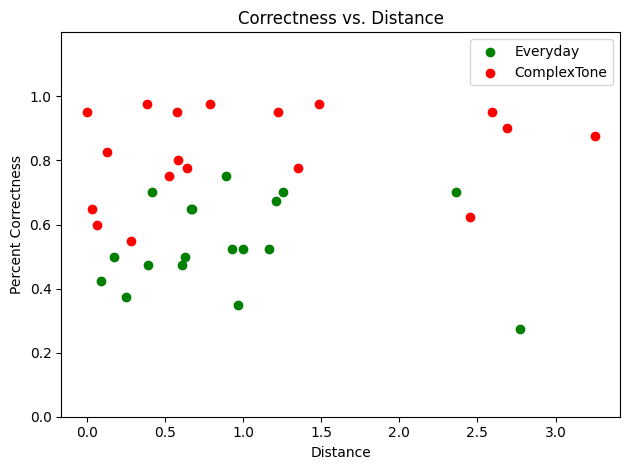

In [118]:
plot_distances1(filtered_df_everyday, filtered_df_complexTone1)

#### Cat Meows vs Complex Tones

In [119]:
# Cat Meows
# distance metric
distanceCM= "/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/8. Similarity in PA task/result/distance_catMeow.csv"
# cat meows
catmeowCorrectness = "/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/9. Similarity in SD task/Cat_CompexTone_result/correctness_other.csv"

# Reading the CSV files
distance_df = pd.read_csv(distanceCM)
correctness_df = pd.read_csv(catmeowCorrectness)

# Processing the correctness data
results = []
for index, row in correctness_df.iterrows():
    
    sequence_names = row['Sequence_Names']
    switch_name = row['Stim_Ind']
    percent_correctness = row['Percent_Correctness']

    distance = calculate_distances2(sequence_names, switch_name, distance_df)
   
    results.append({
        'Sequence': sequence_names,
        'Switch': switch_name,
        'Correctness': percent_correctness,
        'Distance': abs(distance),
    })

results_df_cat = pd.DataFrame(results)
#print(results_df_everyday)
# Filter out the rows where distance is -1
filtered_df_cat = results_df_cat[(results_df_cat['Distance'] != 1)]
print(filtered_df_cat)

                                             Sequence  Switch  Correctness  \
0   11_500ms-changeduration_Stretch__0_3, 18_500ms...     1.0     0.487805   
1   11_500ms-changeduration_Stretch__0_3, 18_500ms...     1.0     0.463415   
2   11_500ms-changeduration_Stretch__0_3, 1_500ms-...     2.0     0.926829   
3   18_500ms-changeduration_Stretch__0_3, 17_500ms...     2.0     0.756098   
4   18_500ms-changeduration_Stretch__0_3, 8_500ms-...     2.0     0.487805   
5   1_500ms-changeduration_Stretch__0_3, 11_500ms-...     1.0     0.268293   
6   1_500ms-changeduration_Stretch__0_3, 18_500ms-...     2.0     0.707317   
7   1_500ms-changeduration_Stretch__0_3, 24_500ms-...     2.0     0.731707   
8   1_500ms-changeduration_Stretch__0_3, 25_500ms-...     2.0     0.560976   
9   1_500ms-changeduration_Stretch__0_3, 26_500ms-...     1.0     0.317073   
10  24_500ms-changeduration_Stretch__0_3, 17_500ms...     0.0     0.536585   
11  24_500ms-changeduration_Stretch__0_3, 26_500ms...     0.0   

In [120]:
# Complex Tones
# distance metric
distanceCT= "/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/8. Similarity in PA task/result/distance_complexTone2.csv"
# complex tone
complexToneCorrectness = '/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/9. Similarity in SD task/Cat_CompexTone_result/correctness_complexTone.csv'

# Reading the CSV files
distance_df = pd.read_csv(distanceCT)
correctness_df = pd.read_csv(complexToneCorrectness)

# Processing the correctness data
results = []
for index, row in correctness_df.iterrows():
    
    sequence_names = row['Sequence_Names']
    switch_name = row['Stim_Ind']
    percent_correctness = row['Percent_Correctness']

    distance = calculate_distances(sequence_names, switch_name, distance_df)
   
    results.append({
        'Sequence': sequence_names,
        'Switch': switch_name,
        'Correctness': percent_correctness,
        'Distance': abs(distance),
    })

results_df_complexTone = pd.DataFrame(results)
filtered_df_complexTone2 = results_df_complexTone[(results_df_complexTone['Distance'] != -1)]
print(filtered_df_complexTone2)

                         Sequence  Switch  Correctness  Distance
0        A#4_Bb4, A4, F4, C#4_Db4     2.0     0.902439  0.353846
1        A#4_Bb4, D5, C5, F#4_Gb4     1.0     0.951220  1.439394
2             A4, D#4_Eb4, C4, D4     0.0     0.902439  1.433333
3             B4, C#4_Db4, D4, G4     0.0     0.902439  1.818182
4        C#4_Db4, C4, D5, A#4_Bb4     1.0     1.000000  3.783217
5   C#4_Db4, E4, C#5_Db5, D#5_Eb5     2.0     0.926829  0.111111
6             C#5_Db5, B4, F4, A4     2.0     0.951220  1.250000
7        C#5_Db5, C4, C5, D#4_Eb4     2.0     0.975610  2.007692
8   C#5_Db5, C4, D#5_Eb5, A#4_Bb4     0.0     0.829268  2.181818
9        D#5_Eb5, C#5_Db5, C4, B4     1.0     0.829268  3.500000
10                 D5, A4, D4, F4     0.0     0.902439  1.100000
11  D5, D#5_Eb5, C#5_Db5, G#4_Ab4     1.0     0.902439  0.444444
12            E4, A4, G#4_Ab4, F4     2.0     0.902439  1.200000
13            E4, C4, A#4_Bb4, B4     0.0     0.634146  0.885714
14       F#4_Gb4, C4, B4,

#### correlation analysis 

In [121]:
filtered_df_cat.name = 'filtered_df_cat'
filtered_df_complexTone2.name = 'filtered_df_complexTone'
calculate_and_print_correlation(filtered_df_cat, 'Distance')
calculate_and_print_correlation(filtered_df_complexTone2, 'Distance')

# For combined data
combined_df_mean = pd.concat([filtered_df_cat[['Distance', 'Correctness']], 
                              filtered_df_complexTone2[['Distance', 'Correctness']]])
combined_df_mean.name = 'combined_df'
calculate_and_print_correlation(combined_df_mean, 'Distance')


r (cat - Distance): -0.024, t-value: -0.096, p-value: 0.924, dof: 16
r (complexTone - Distance): 0.124, t-value: 0.502, p-value: 0.623, dof: 16
r (df - Distance): 0.154, t-value: 0.906, p-value: 0.371, dof: 34


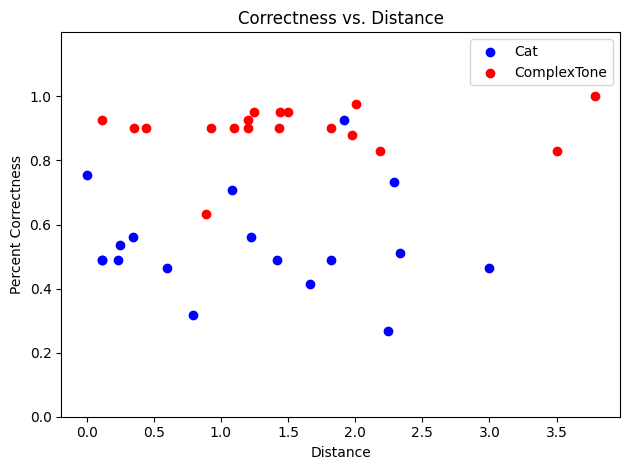

In [122]:
plot_distances2(filtered_df_cat, filtered_df_complexTone2)

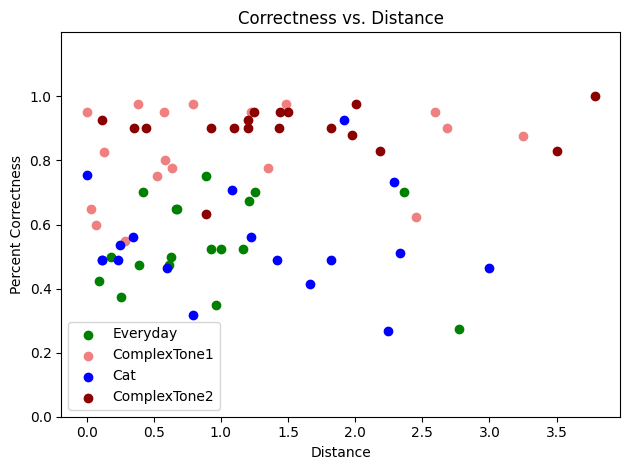

In [123]:
plot_distances_combined(filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2)

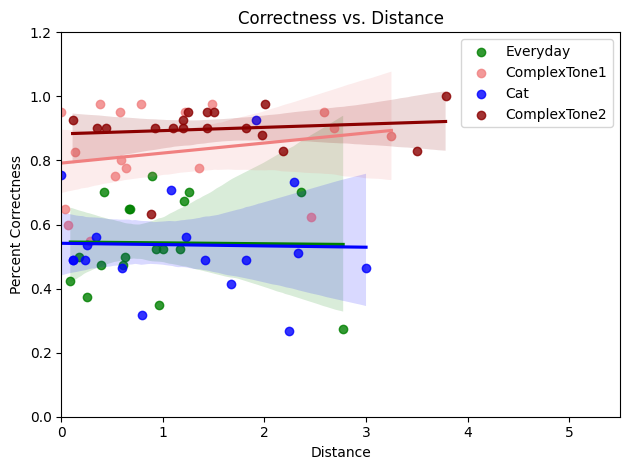

In [124]:
plot_distances_with_regression(filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2)

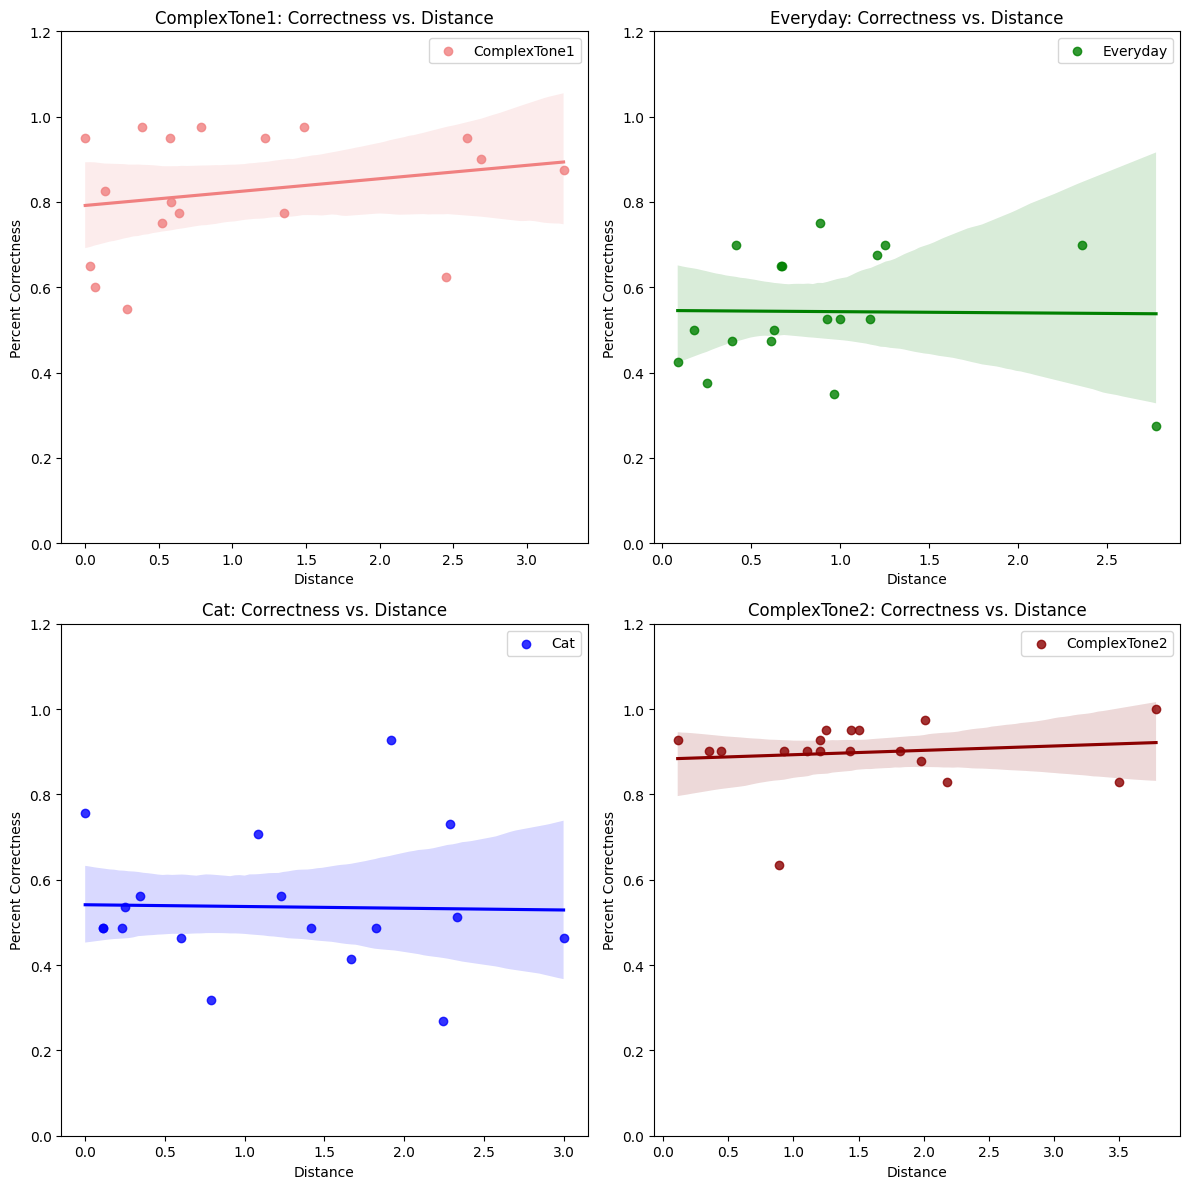

In [125]:
plot_distances_2x2_subplots(filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2)

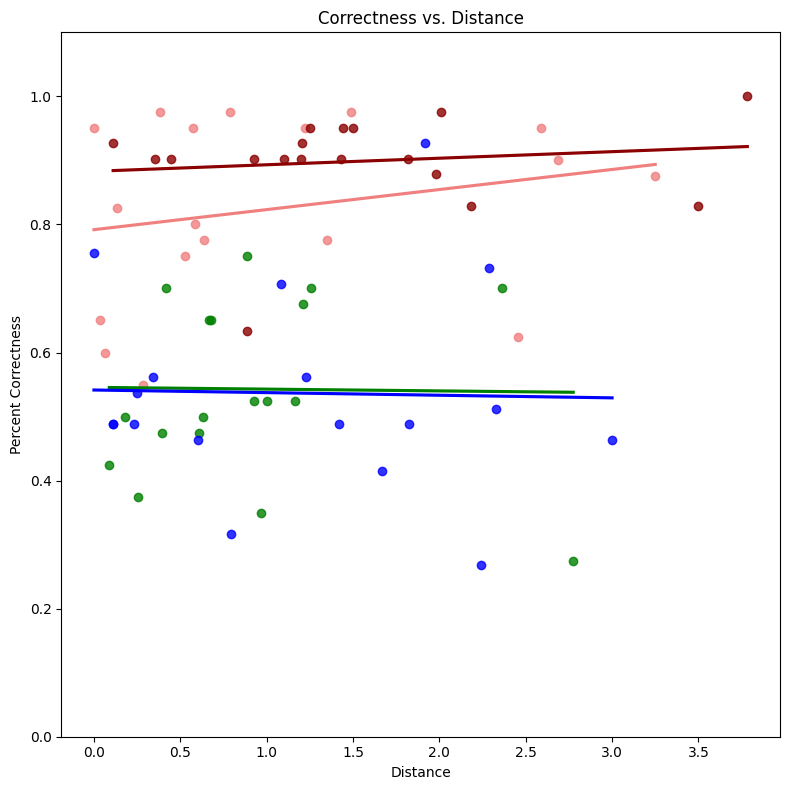

In [126]:
modified_plot_distances_with_regression(filtered_df_everyday, filtered_df_complexTone1, filtered_df_cat, filtered_df_complexTone2)